## Análise exploratória dos dados, treinamento, validação e teste da rede neural MLP no Dataset Titanic - Terceira Avaliação Redes Neurais
### Discente: João Pedro de Alcântara Lima

Neste trabalho, foi desenvolvido um pipeline completo de análise e modelagem preditiva utilizando o dataset do Titanic, com o objetivo de prever a sobrevivência dos passageiros a partir de variáveis disponíveis. O processo envolveu diversas etapas, desde a análise exploratória dos dados até a avaliação detalhada do desempenho do modelo de rede neural MLP.

#### 1. Análise Exploratória dos Dados

A análise exploratória foi fundamental para compreender a distribuição das variáveis e suas relações com a variável alvo (`Survived`). Foram geradas tabelas e gráficos para investigar a taxa de sobrevivência em função do sexo (`Sex`), classe (`Pclass`), idade (`Age`), local de embarque (`Embarked`), entre outros fatores. Observou-se, por exemplo, que mulheres e passageiros da primeira classe apresentaram maiores taxas de sobrevivência. Também foram analisadas as distribuições de variáveis como `SibSp`, `Parch`, `Fare` e `Cabin`, além de cruzamentos entre variáveis para identificar padrões e possíveis desbalanceamentos.

Contagem absoluta de sobreviventes por sexo:
Survived    0    1
Sex               
female     81  233
male      468  109

Percentual de sobreviventes por sexo:
Survived          0          1
Sex                           
female    25.796178  74.203822
male      81.109185  18.890815


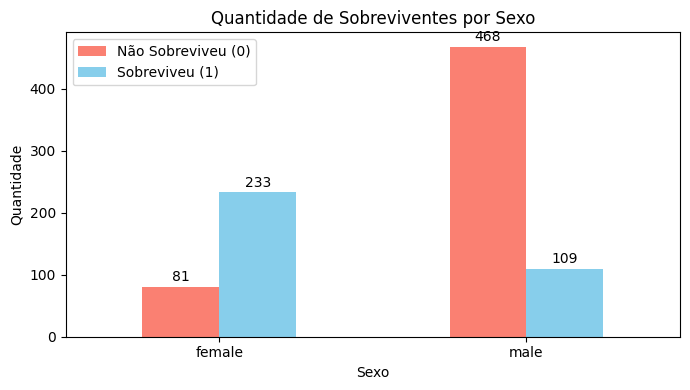

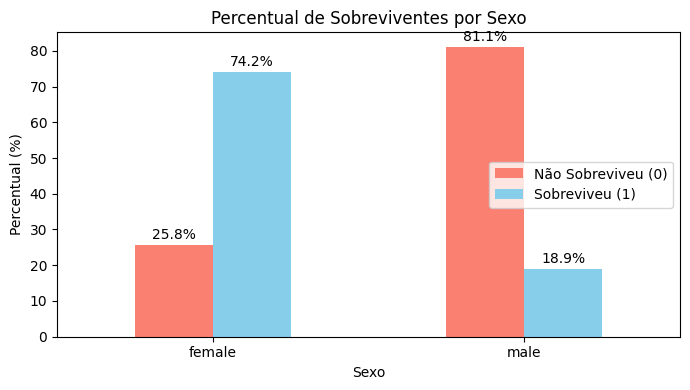

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# 1. Análise quantitativa e relativa de Survived em relação ao Sex
survived_sex_counts = train_df.groupby('Sex')['Survived'].value_counts().unstack().fillna(0)
survived_sex_percent = survived_sex_counts.div(survived_sex_counts.sum(axis=1), axis=0) * 100

print("Contagem absoluta de sobreviventes por sexo:")
print(survived_sex_counts)
print("\nPercentual de sobreviventes por sexo:")
print(survived_sex_percent)

# Plotagem da quantidade absoluta
ax1 = survived_sex_counts.plot(kind='bar', figsize=(7,4), color=['salmon', 'skyblue'])
plt.title('Quantidade de Sobreviventes por Sexo')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')
plt.xticks(rotation=0)
for container in ax1.containers:
    ax1.bar_label(container, padding=2)
plt.legend(['Não Sobreviveu (0)', 'Sobreviveu (1)'])
plt.tight_layout()
plt.show()

# Plotagem do percentual
ax2 = survived_sex_percent.plot(kind='bar', figsize=(7,4), color=['salmon', 'skyblue'])
plt.title('Percentual de Sobreviventes por Sexo')
plt.ylabel('Percentual (%)')
plt.xlabel('Sexo')
plt.xticks(rotation=0)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f%%', padding=2)
plt.legend(['Não Sobreviveu (0)', 'Sobreviveu (1)'])
plt.tight_layout()
plt.show()

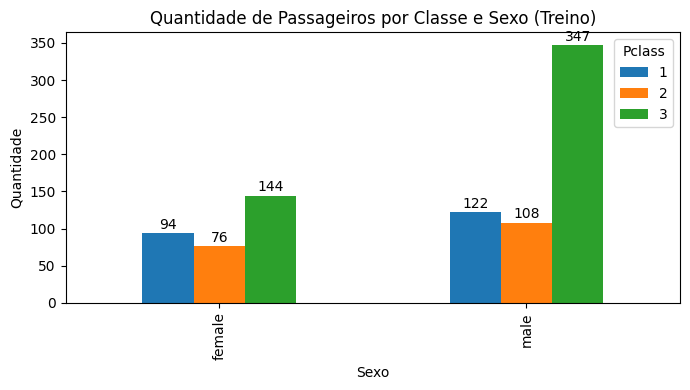

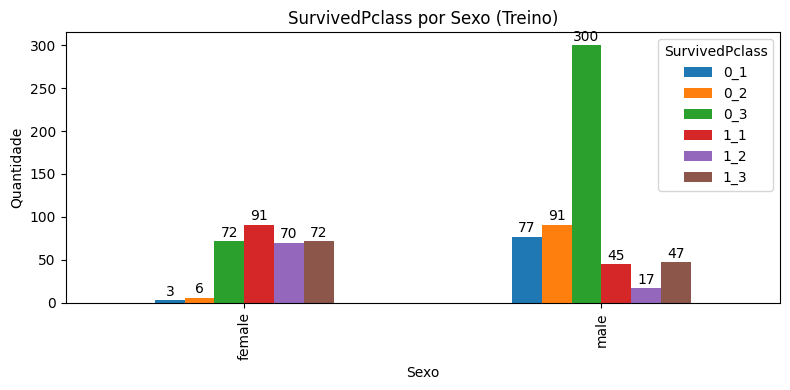

In [70]:
ct = pd.crosstab(train_df['Sex'], train_df['Pclass'])

fig, ax = plt.subplots(figsize=(7,4))
bars = ct.plot(kind='bar', ax=ax) 

plt.title('Quantidade de Passageiros por Classe e Sexo (Treino)')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')

# Adicionar rótulos de dados em cada barra
for container in ax.containers:
    ax.bar_label(container, padding=1)

plt.legend(title='Pclass')
plt.tight_layout()
plt.show()

# 3. Criar a nova classe combinada SurvivedPclass
train_df['SurvivedPclass'] = train_df['Survived'].astype(str) + '_' + train_df['Pclass'].astype(str)

ct = pd.crosstab(train_df['Sex'], train_df['SurvivedPclass'])

fig, ax = plt.subplots(figsize=(8,4))
bars = ct.plot(kind='bar', ax=ax) 

plt.title('SurvivedPclass por Sexo (Treino)')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')

# Adicionar rótulos de dados em cada barra
for container in ax.containers:
    ax.bar_label(container, padding=1)

plt.legend(title='SurvivedPclass')
plt.tight_layout()
plt.show()

#### 2. Pré-processamento e Balanceamento das Classes

O pré-processamento incluiu a limpeza dos dados, tratamento de valores ausentes (como preenchimento de idades e tarifas faltantes com a mediana), e a codificação de variáveis categóricas. Em seguida, os dados foram divididos em conjuntos de treino (80%) e validação (20%), garantindo a estratificação da variável alvo. Para lidar com o desbalanceamento das classes, foi utilizado o método RandomOverSampler, que equilibrou as amostras das classes majoritária e minoritária no conjunto de treino, evitando viés do modelo.


#### 3. Treinamento, Validação e Ajuste de Hiperparâmetros da Rede Neural MLP

O modelo de rede neural MLP foi treinado com os dados balanceados e padronizados, utilizando uma camada oculta e diferentes configurações de hiperparâmetros. O ajuste fino dos hiperparâmetros foi realizado com GridSearchCV, testando diferentes tamanhos de camada oculta, funções de ativação e número de épocas. Durante o treinamento, foram monitoradas as curvas de loss (função de perda) tanto no treino quanto na validação, permitindo identificar o comportamento do modelo e possíveis sinais de overfitting ou underfitting.

Parando treinamento na época 455 (sem melhora na loss de validação por 20 épocas).


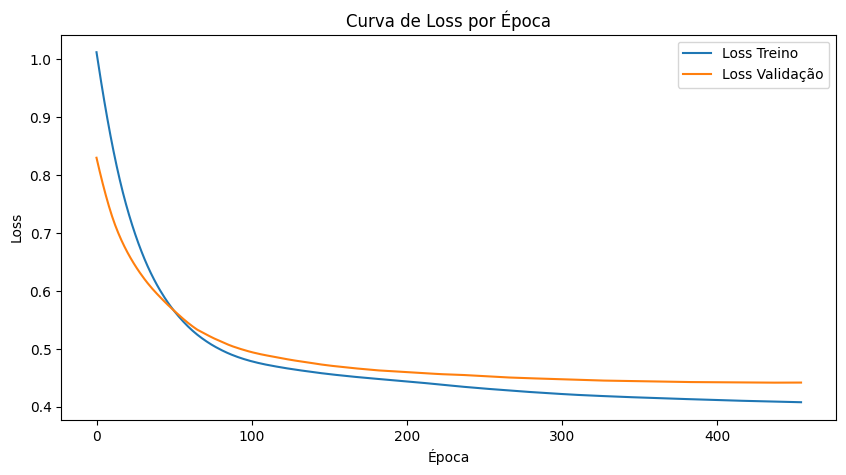

In [71]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import log_loss

# Seleção de features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = train_df[features].copy()
y = train_df['Survived']

# Codificação de variáveis categóricas
X = pd.get_dummies(X, columns=['Sex', 'Embarked'], drop_first=True)
X['Age'] = X['Age'].fillna(X['Age'].median())
X['Fare'] = X['Fare'].fillna(X['Fare'].median())

# Separar em treino (80%) e validação (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Balanceamento de classes usando RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

# Padronização dos dados
scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_val_scaled = scaler.transform(X_val)

# Treinamento manual com partial_fit
max_epochs = 500 # testei com 200, 300, 500 e 1000
mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', max_iter=1, warm_start=True, random_state=42)
classes = np.unique(y_train_bal)
train_loss = []
val_loss = []
train_acc = []
val_acc = []

patience = 20  # número de épocas sem melhora antes de parar
best_val_loss = float('inf')
epochs_no_improve = 0
best_epoch = 0

for epoch in range(max_epochs):
    mlp.partial_fit(X_train_bal_scaled, y_train_bal, classes=classes)
    y_train_pred = mlp.predict(X_train_bal_scaled)
    y_val_pred = mlp.predict(X_val_scaled)
    y_train_pred_proba = mlp.predict_proba(X_train_bal_scaled)
    y_val_pred_proba = mlp.predict_proba(X_val_scaled)
    train_loss.append(log_loss(y_train_bal, y_train_pred_proba))
    val_loss.append(log_loss(y_val, y_val_pred_proba))

    # Early stopping
    if val_loss[-1] < best_val_loss - 1e-4:
        best_val_loss = val_loss[-1]
        best_epoch = epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    if epochs_no_improve >= patience:
        print(f"Parando treinamento na época {epoch+1} (sem melhora na loss de validação por {patience} épocas).")
        break

# Plotar curva de loss e acurácia
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Loss Treino')
plt.plot(val_loss, label='Loss Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Loss por Época')
plt.legend()
plt.show()

#### 4. Avaliação do Modelo

A avaliação do modelo foi conduzida no conjunto de validação, utilizando métricas como acurácia, precisão, recall, F1-score e matriz de confusão. Também foi analisada a curva ROC e o valor da AUC para avaliar a capacidade discriminativa do modelo. Foram identificados os principais tipos de erro (falsos positivos e falsos negativos) e analisados exemplos concretos desses erros, além de calcular a acurácia segmentada por grupos, como sexo dos passageiros. A importância das variáveis foi avaliada a partir dos pesos da primeira camada da rede, destacando quais atributos mais influenciaram as decisões do modelo.

In [72]:
from sklearn.metrics import classification_report

# Avaliação no conjunto de validação
val_pred = mlp.predict(X_val_scaled)
print(classification_report(y_val, val_pred))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       110
           1       0.78      0.72      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



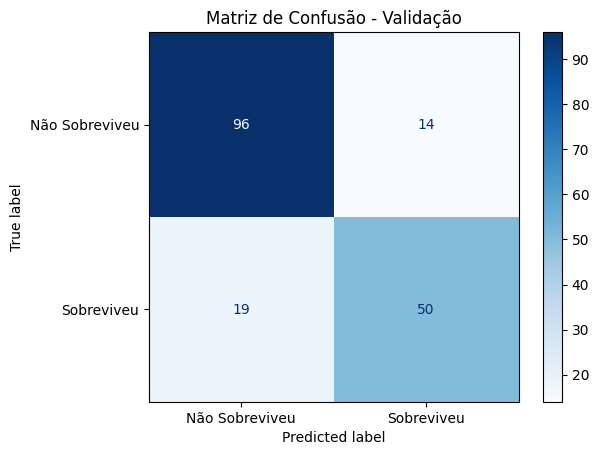

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Sobreviveu', 'Sobreviveu'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão - Validação')
plt.show()

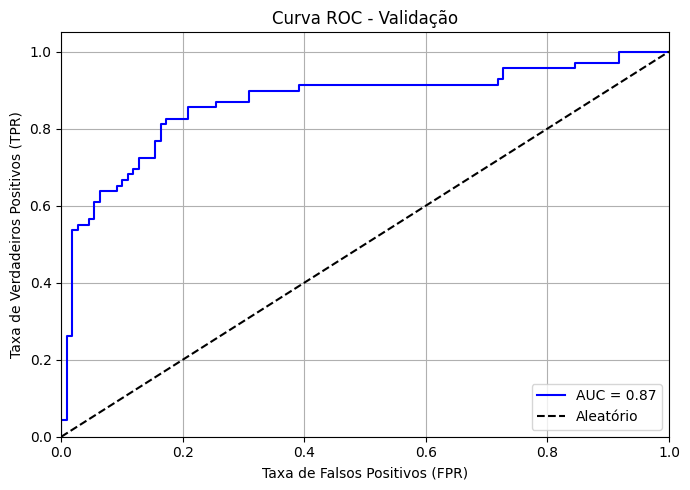

In [74]:
from sklearn.metrics import roc_curve, auc

y_val_proba = mlp.predict_proba(X_val_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Validação')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 5. Testes e Análises Adicionais

Após a validação, o modelo foi aplicado ao conjunto de teste para prever a sobrevivência dos passageiros. Diversas análises complementares foram realizadas, como a identificação das cabines com maior proporção de sobreviventes, locais de embarque mais favoráveis em cada classe, e faixas de preço da passagem (`Fare`) e idade (`Age`) que mais impactaram a sobrevivência. Foram gerados gráficos para visualizar a influência dessas variáveis e entender melhor o comportamento do modelo. Por fim, foram analisados os erros do modelo por meio de heatmaps e contagens, permitindo identificar padrões nos casos em que o modelo apresentou maior dificuldade.

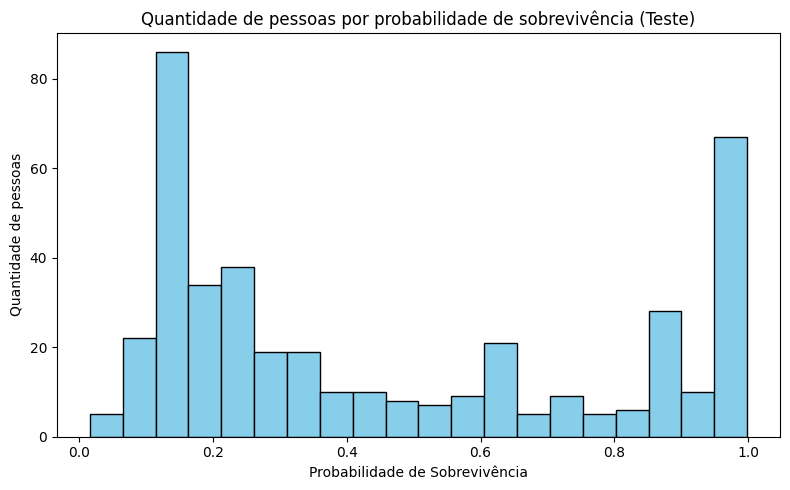

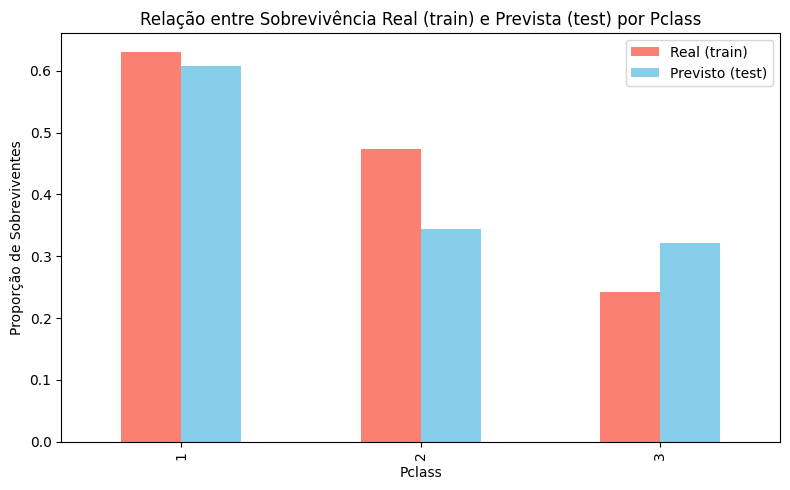

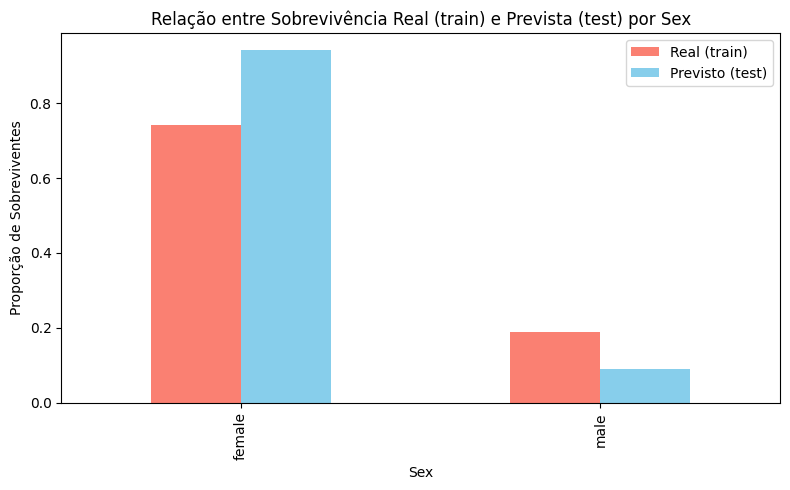

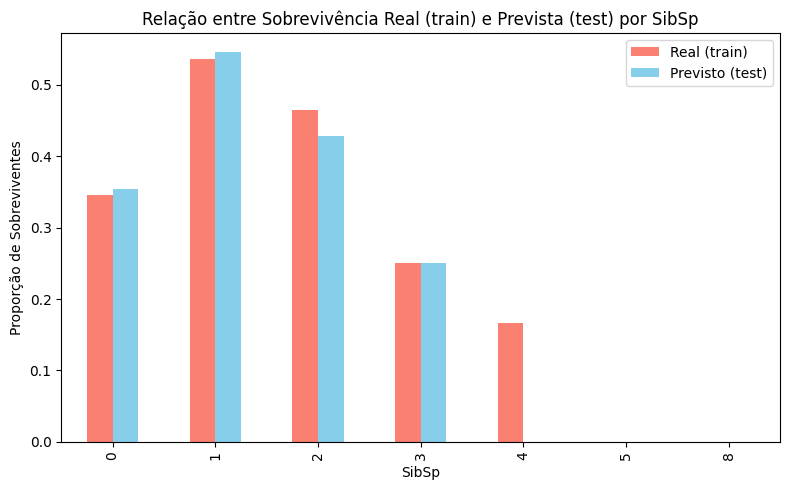

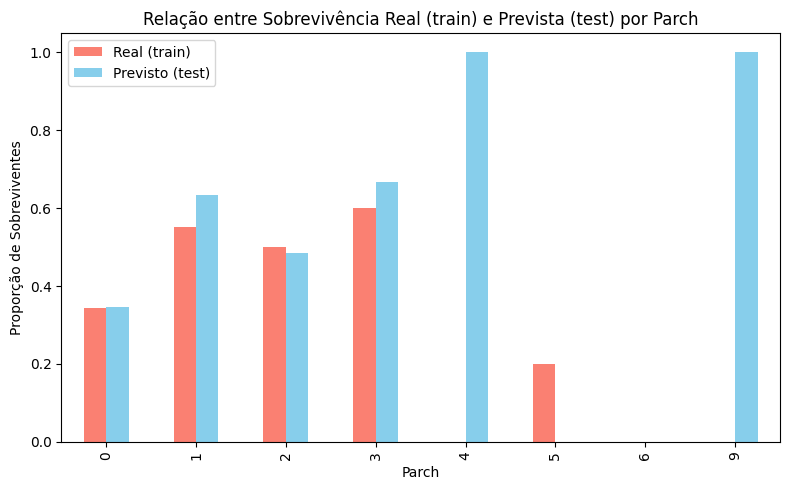

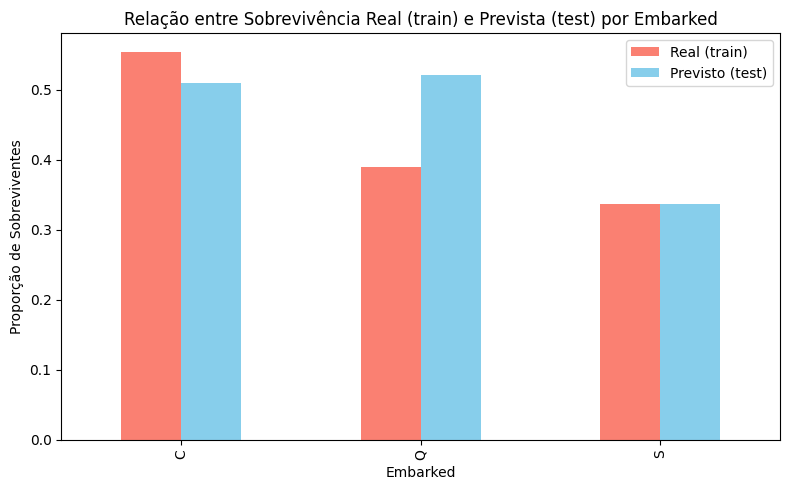

In [82]:
# Avaliação no conjunto de teste
test_df = pd.read_csv("test.csv")
X_test = test_df[features].copy()
X_test = pd.get_dummies(X_test, columns=['Sex', 'Embarked'], drop_first=True)
X_test['Age'] = X_test['Age'].fillna(X_test['Age'].median())
X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].median())
X_test_scaled = scaler.transform(X_test)

# Previsão no conjunto de teste
y_test_pred = mlp.predict(X_test_scaled)
y_test_pred_proba = mlp.predict_proba(X_test_scaled)

# Exibindo as previsões
test_df['Predicted_Survived'] = y_test_pred

# Plotando distribuição de probabilidades
plt.figure(figsize=(8,5))
plt.hist(y_test_pred_proba[:, 1], bins=20, color='skyblue', edgecolor='black')
plt.title('Quantidade de pessoas por probabilidade de sobrevivência (Teste)')
plt.xlabel('Probabilidade de Sobrevivência')
plt.ylabel('Quantidade de pessoas')
plt.tight_layout()
plt.show()

# Plotando relação entre 'Predicted_Survived' e cada feature
for feature in ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']:
    plt.figure(figsize=(8,5))
    # Proporção de sobreviventes prevista (teste)
    pred = test_df.groupby(feature)['Predicted_Survived'].mean()
    # Proporção de sobreviventes real (treino)
    real = train_df.groupby(feature)['Survived'].mean()
    df_plot = pd.DataFrame({'Real (train)': real, 'Previsto (test)': pred})
    df_plot.plot(kind='bar', ax=plt.gca(), color=['salmon', 'skyblue'])
    plt.ylabel('Proporção de Sobreviventes')
    plt.title(f'Relação entre Sobrevivência Real (train) e Prevista (test) por {feature}')
    plt.xlabel(feature)
    plt.tight_layout()
    plt.show()

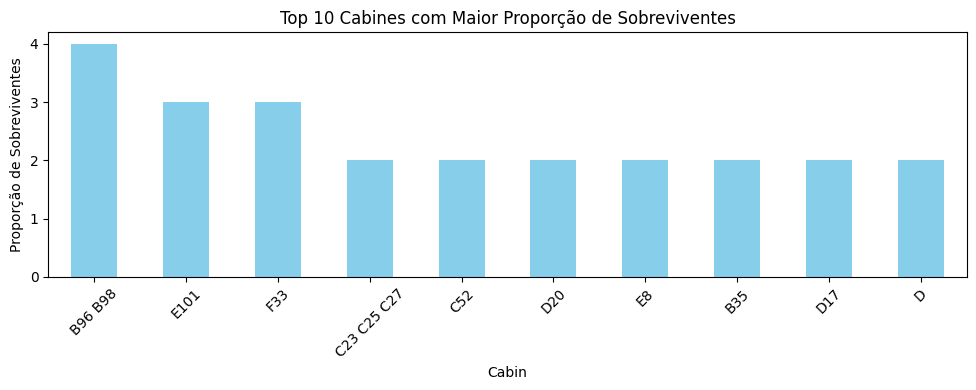

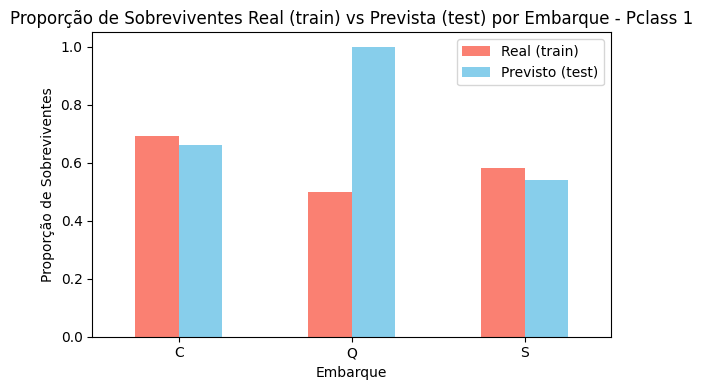

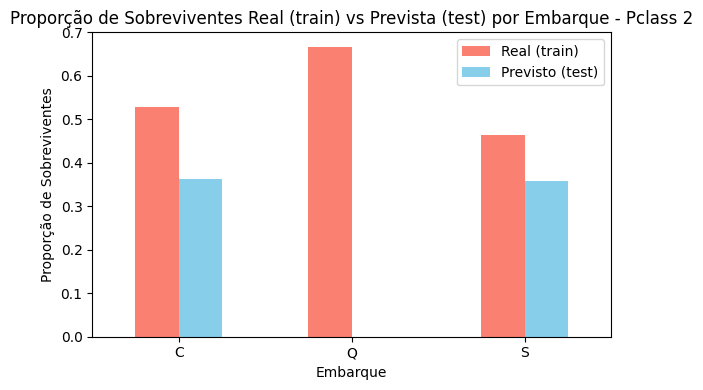

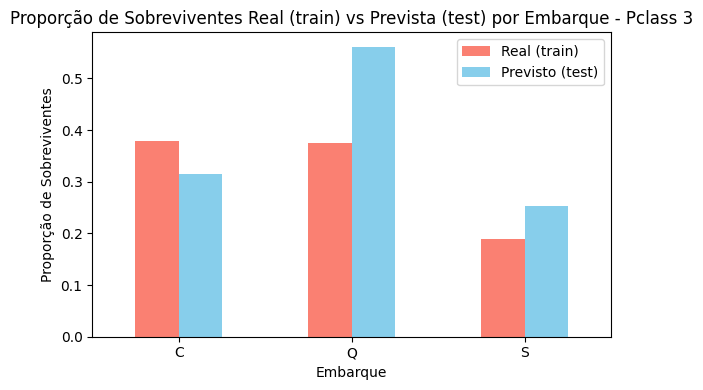

<Figure size 800x500 with 0 Axes>

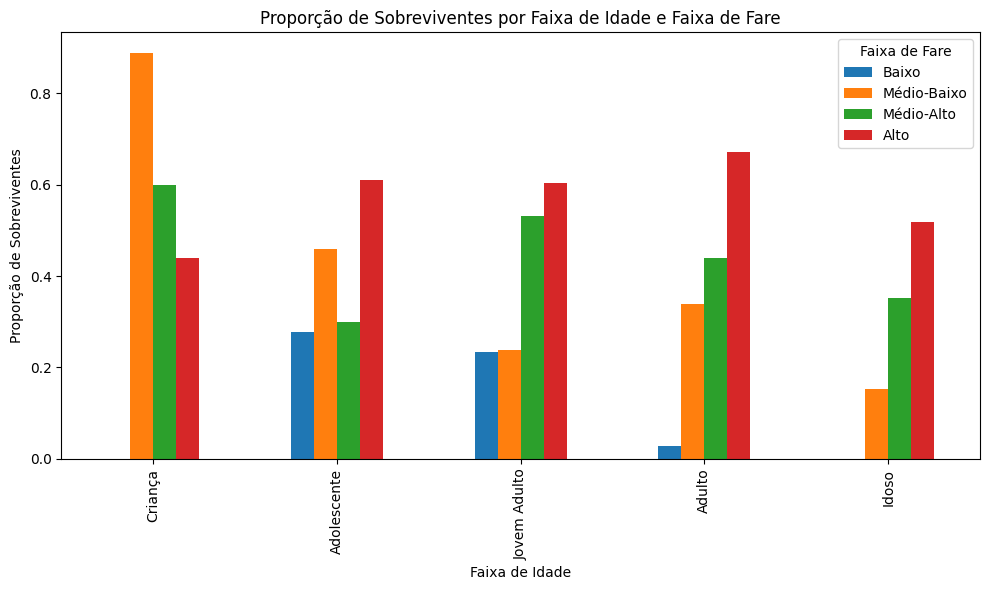

In [88]:
# Análise: Cabines com mais sobreviventes (apenas real)
cabine_surv = train_df.groupby('Cabin')['Survived'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,4))
cabine_surv.plot(kind='bar', color='skyblue')
plt.title('Top 10 Cabines com Maior Proporção de Sobreviventes')
plt.xlabel('Cabin')
plt.ylabel('Proporção de Sobreviventes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Análise: Embarque com mais sobreviventes por Pclass (real vs previsto)
for pclass in sorted(train_df['Pclass'].unique()):
    real_emb = train_df[train_df['Pclass']==pclass].groupby('Embarked')['Survived'].mean().sort_index()
    plt.figure(figsize=(6,4))
    if 'Predicted_Survived' in test_df.columns:
        pred_emb = test_df[test_df['Pclass']==pclass].groupby('Embarked')['Predicted_Survived'].mean().reindex(real_emb.index)
        df_emb = pd.DataFrame({'Real (train)': real_emb, 'Previsto (test)': pred_emb})
        df_emb.plot(kind='bar', ax=plt.gca(), color=['salmon', 'skyblue'])
        plt.title(f'Proporção de Sobreviventes Real (train) vs Prevista (test) por Embarque - Pclass {pclass}')
    else:
        real_emb.plot(kind='bar', color='salmon')
        plt.title(f'Proporção de Sobreviventes por Embarque - Pclass {pclass} (Real)')
    plt.xlabel('Embarque')
    plt.ylabel('Proporção de Sobreviventes')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Análise: Faixas de Fare e Ages que mais sobreviveram (apenas real)
fare_bins = pd.qcut(train_df['Fare'], q=4, labels=['Baixo','Médio-Baixo','Médio-Alto','Alto'])
age_bins = pd.cut(train_df['Age'], bins=[0,12,18,30,50,80], labels=['Criança','Adolescente','Jovem Adulto','Adulto','Idoso'])
fare_age_surv = train_df.copy()
fare_age_surv['FareBin'] = fare_bins
fare_age_surv['AgeBin'] = age_bins
plt.figure(figsize=(8,5))
surv_pivot = fare_age_surv.pivot_table(index='AgeBin', columns='FareBin', values='Survived', aggfunc='mean')
surv_pivot.plot(kind='bar', figsize=(10,6))
plt.title('Proporção de Sobreviventes por Faixa de Idade e Faixa de Fare')
plt.ylabel('Proporção de Sobreviventes')
plt.xlabel('Faixa de Idade')
plt.legend(title='Faixa de Fare')
plt.tight_layout()
plt.show()

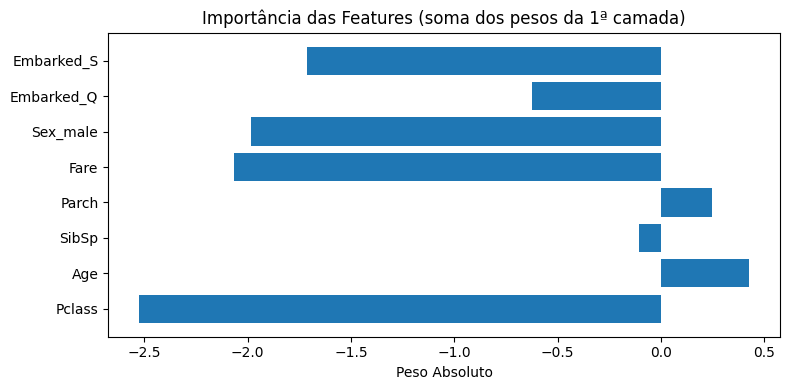

In [78]:
importances = mlp.coefs_[0].sum(axis=1)
feature_names = X_train.columns
plt.figure(figsize=(8,4))
plt.barh(feature_names, importances)
plt.title('Importância das Features (soma dos pesos da 1ª camada)')
plt.xlabel('Peso Absoluto')
plt.tight_layout()
plt.show()

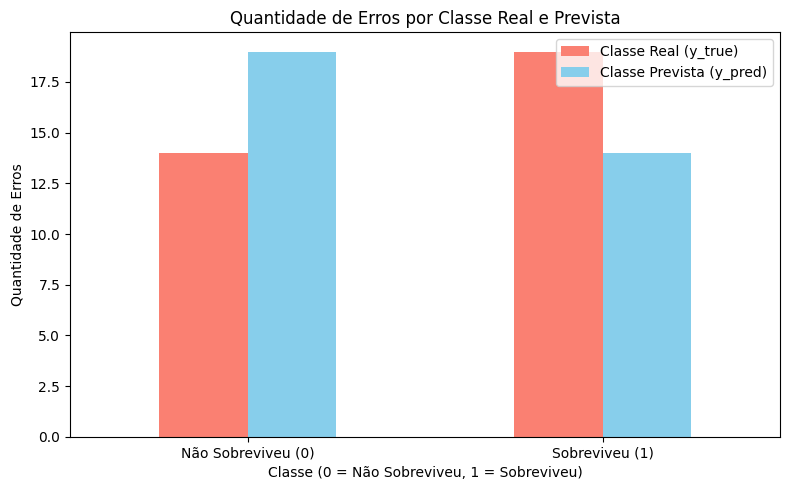

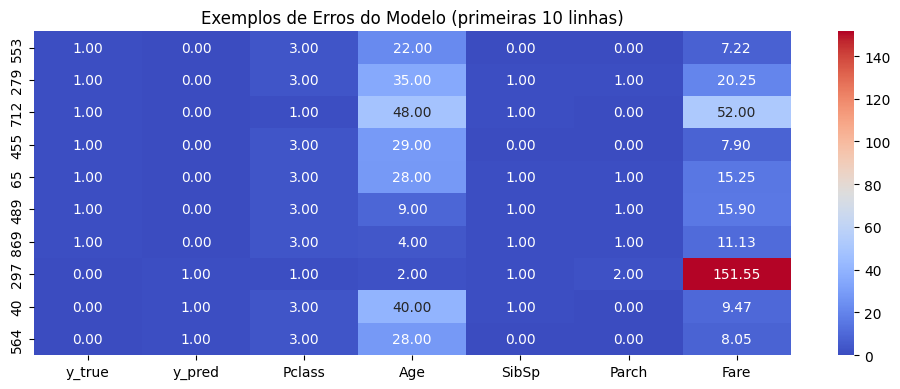

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Análise dos erros do modelo com plot
val_results = X_val.copy()
val_results['y_true'] = y_val.values
val_results['y_pred'] = val_pred
val_results['erro'] = val_results['y_true'] != val_results['y_pred']

# Unindo os dois gráficos em um só
erro_real = val_results[val_results['erro']].groupby('y_true').size()
erro_pred = val_results[val_results['erro']].groupby('y_pred').size()
df_erro = pd.DataFrame({'Classe Real (y_true)': erro_real, 'Classe Prevista (y_pred)': erro_pred})

df_erro.plot(kind='bar', color=['salmon', 'skyblue'], figsize=(8,5))
plt.title('Quantidade de Erros por Classe Real e Prevista')
plt.xlabel('Classe (0 = Não Sobreviveu, 1 = Sobreviveu)')
plt.ylabel('Quantidade de Erros')
plt.xticks([0,1], ['Não Sobreviveu (0)', 'Sobreviveu (1)'], rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

# Heatmap dos erros (mantido igual)
cols_to_show = ['y_true', 'y_pred']
for col in ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']:
    if col in val_results.columns:
        cols_to_show.append(col)

heatmap_data = val_results[val_results['erro']].head(10)[cols_to_show].astype(float)

plt.figure(figsize=(10,4))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Exemplos de Erros do Modelo (primeiras 10 linhas)')
plt.tight_layout()
plt.show()

### Referências bibliográficas

- KAGGLE. Titanic - Machine Learning from Disaster. Disponível em: <https://www.kaggle.com/c/titanic>. Acesso em: 04 jul. 2025.

- TAVARES, Lucas. Dados desbalanceados: o que são e como evitá-los. *Turing Talks*, Medium, 2020. Disponível em: <https://medium.com/turing-talks/dados-desbalanceados-o-que-s%C3%A3o-e-como-evit%C3%A1-los-43df4f49732b>. Acesso em: 04 jul. 2025.

- Pandas: Python Data Analysis Library. Disponível em: <https://pandas.pydata.org/>. Acesso em: 04 jul. 2025.

- Scikit-learn: Machine Learning in Python. Disponível em: <https://scikit-learn.org/stable/>. Acesso em: 04 jul. 2025.